# Parkinson's Electrophysiological Signal Dataset (PESD) Analysis
## DANDI:001333

**⚠️ Notice: This notebook was AI-generated with human supervision and has not been fully verified. Users should exercise caution when interpreting the code or results.**

This notebook provides an introduction to working with the Parkinson's Electrophysiological Signal Dataset (PESD), which contains electrophysiological signals from simulated healthy and parkinsonian subjects. The dataset focuses on beta oscillations (13-30 Hz) in the subthalamic nucleus (STN), which are typical pathological biomarkers for Parkinson's Disease symptoms.

## Dataset Overview

The dataset contains:
- Beta Average Rectified Voltage (ARV) signals in the frequency domain
- Local Field Potential (LFP) signals from the Subthalamic Nucleus (STN) in the time domain

This data was generated from a cortico-basal-ganglia network computational model, as described in Fleming et al.'s article on "Simulation of Closed-Loop Deep Brain Stimulation Control Schemes for Suppression of Pathological Beta Oscillations in Parkinson's Disease".

In [1]:
# Import required libraries
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt

## Loading and Examining the Data

We'll start by loading the NWB file and examining its basic structure. For this demonstration, we'll use the healthy simulated data file.

In [2]:
# Load the NWB file
f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/001333/assets/5409700b-e080-44e6-a6db-1d3e8890cd6c/nwb.lindi.json")
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Display basic information
print("Dataset Information:")
print(f"Description: {nwb.session_description}")
print(f"Lab: {nwb.lab}")
print(f"Subject: {nwb.subject.subject_id}")
print(f"Keywords: {', '.join(nwb.keywords)}")

Dataset Information:
Description: Parkinson's Electrophysiological Signal Dataset (PESD) Generated from Simulation
Lab: BrainX Lab
Subject: healthy_simulated_data
Keywords: ecephys, LFP, Parkinson's Disease, Beta Band


## Understanding the Recording Setup

The dataset includes recordings from multiple electrodes in the simulated cortico-basal-ganglia network. Let's examine the electrode configuration:

In [3]:
# Get electrode information
electrodes = nwb.ec_electrodes
locations = electrodes["location"].data[:]
labels = electrodes["label"].data[:]

print("\nElectrode Configuration:")
print("----------------------")
for i, (loc, label) in enumerate(zip(locations, labels)):
    print(f"Electrode {i+1}: Location={loc}, Label={label}")


Electrode Configuration:
----------------------
Electrode 1: Location=Simulated Cortico-basal-ganglia network of brain, Label=shank0_elec0
Electrode 2: Location=Simulated Cortico-basal-ganglia network of brain, Label=shank0_elec1
Electrode 3: Location=Simulated Cortico-basal-ganglia network of brain, Label=shank0_elec2
Electrode 4: Location=Simulated Cortico-basal-ganglia network of brain, Label=shank1_elec0
Electrode 5: Location=Simulated Cortico-basal-ganglia network of brain, Label=shank1_elec1
Electrode 6: Location=Simulated Cortico-basal-ganglia network of brain, Label=shank1_elec2
Electrode 7: Location=Simulated Cortico-basal-ganglia network of brain, Label=shank2_elec0
Electrode 8: Location=Simulated Cortico-basal-ganglia network of brain, Label=shank2_elec1
Electrode 9: Location=Simulated Cortico-basal-ganglia network of brain, Label=shank2_elec2
Electrode 10: Location=Simulated Cortico-basal-ganglia network of brain, Label=shank3_elec0
Electrode 11: Location=Simulated Cortico

## Analyzing LFP Signals

Local Field Potentials (LFPs) are derived from the synchronized activity of neuron populations between the cortex, STN, and thalamus. We'll analyze these signals focusing on the beta band (13-30 Hz), which is particularly relevant for Parkinson's Disease.

First, let's define some helper functions for our analysis:

In [4]:
def get_band_power(data, fs, band, window_sec=1):
    """Calculate average power in a specific frequency band"""
    nperseg = min(int(window_sec * fs), data.shape[0])
    frequencies, psd = signal.welch(data, fs=fs, nperseg=nperseg)
    band_mask = (frequencies >= band[0]) & (frequencies <= band[1])
    return np.mean(psd[band_mask])

def calculate_arv(data, fs, center_freq, bandwidth=8):
    """
    Calculate Average Rectified Value using Chebyshev bandpass filter
    as described in the dataset documentation
    """
    nyquist = fs / 2
    low = (center_freq - bandwidth/2) / nyquist
    high = (center_freq + bandwidth/2) / nyquist
    b, a = signal.cheby1(4, 1, [low, high], btype='band')
    filtered = filtfilt(b, a, data)
    return np.mean(np.abs(filtered))

Let's first look at the raw LFP signal, then analyze its frequency components. We'll focus on the first 10 seconds of recording to keep the computation manageable:

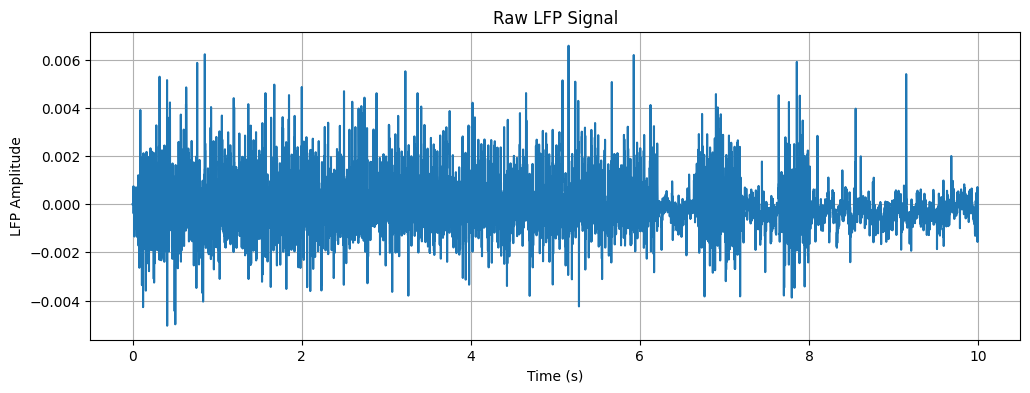

Signal Properties:
Sampling Rate: 2000.0 Hz
Duration: 10 seconds
Number of samples: 20000


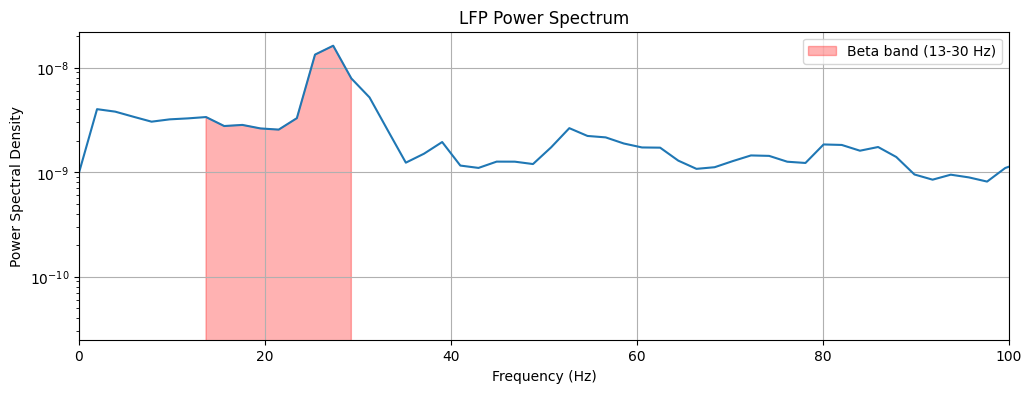

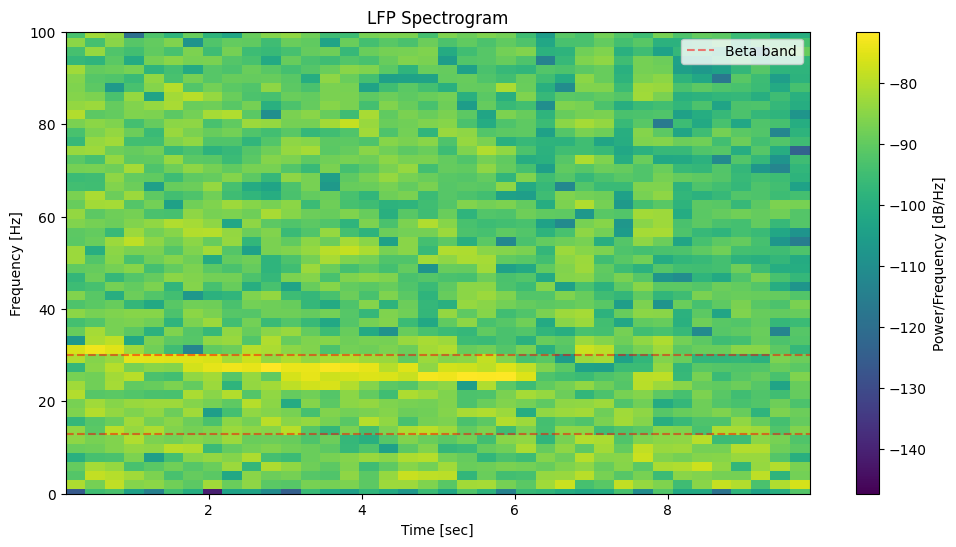

In [5]:
# Get LFP data and plot raw signal
lfp = nwb.processing["ecephys"]["LFP"]["LFP"]
sampling_rate = lfp.rate

# Get 10 seconds of data
segment_duration = 10
n_samples = int(segment_duration * sampling_rate)
data = lfp.data[:n_samples]
time = np.arange(n_samples) / sampling_rate

# Plot raw LFP signal
plt.figure(figsize=(12, 4))
plt.plot(time, data)
plt.xlabel('Time (s)')
plt.ylabel('LFP Amplitude')
plt.title('Raw LFP Signal')
plt.grid(True)
plt.show()

print(f"Signal Properties:")
print(f"Sampling Rate: {sampling_rate} Hz")
print(f"Duration: {segment_duration} seconds")
print(f"Number of samples: {n_samples}")

# Calculate power spectrum
frequencies, psd = signal.welch(data, fs=sampling_rate, nperseg=1024)

# Plot power spectrum with beta band highlighted
plt.figure(figsize=(12, 4))
plt.semilogy(frequencies, psd)
plt.fill_between(frequencies, psd, 
                 where=(frequencies >= 13) & (frequencies <= 30),
                 alpha=0.3, color='r', label='Beta band (13-30 Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('LFP Power Spectrum')
plt.grid(True)
plt.legend()
plt.xlim(0, 100)  # Focus on frequencies up to 100 Hz
plt.show()

# Define frequency bands
bands = {
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 100)
}

# Calculate and plot spectrogram
f, t, Sxx = signal.spectrogram(data, fs=sampling_rate, nperseg=1024, noverlap=512)
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('LFP Spectrogram')
plt.colorbar(label='Power/Frequency [dB/Hz]')
# Highlight beta band
plt.axhline(y=13, color='r', linestyle='--', alpha=0.5, label='Beta band')
plt.axhline(y=30, color='r', linestyle='--', alpha=0.5)
plt.ylim(0, 100)
plt.legend()
plt.show()

## Beta Band Analysis

A key feature of this dataset is the Average Rectified Value (ARV) calculation for the beta band. The ARV is calculated by:
1. Filtering the LFP signal using a fourth-order Chebyshev band-pass filter
2. Using an 8 Hz bandwidth centered around the peak of the LFP power spectrum
3. Fully rectifying the filtered signal

Let's analyze the beta band activity:

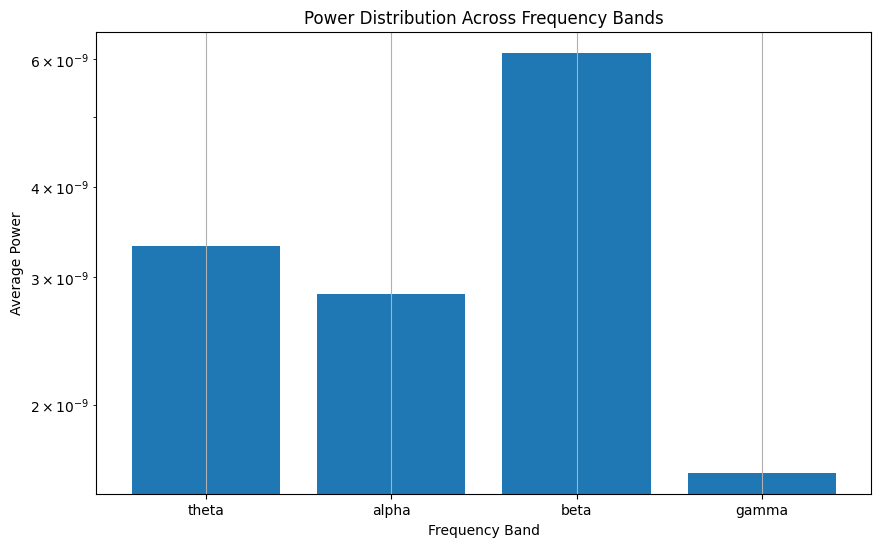

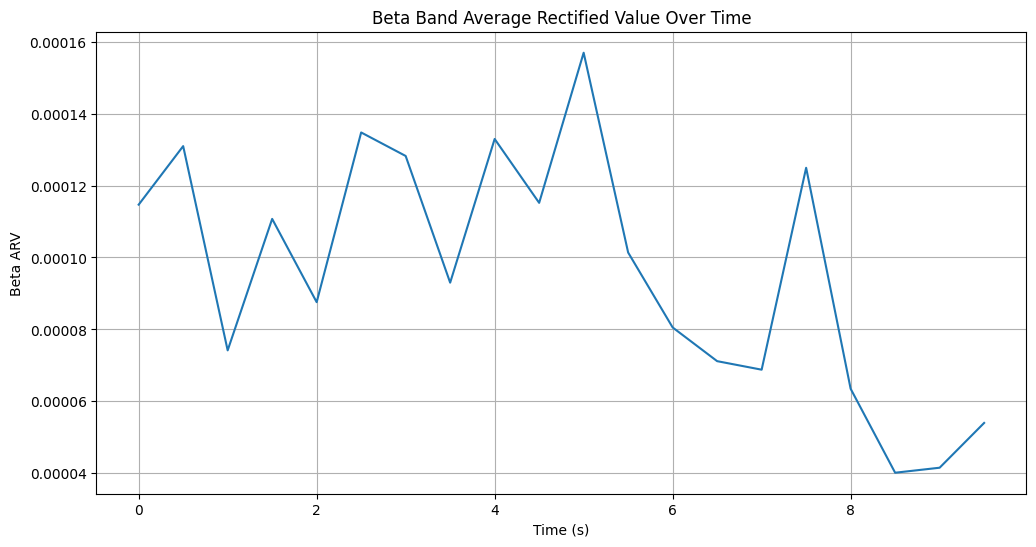


Power Distribution Across Frequency Bands:
Theta: 23.85%
Alpha: 20.46%
Beta: 44.09%
Gamma: 11.60%

Beta Band ARV Statistics:
Mean ARV: 0.000096
Max ARV: 0.000157
Min ARV: 0.000040
ARV Standard Deviation: 0.000033


In [6]:
# Calculate power in different frequency bands
powers = {band: [] for band in bands.keys()}
for band_name, band_range in bands.items():
    power = get_band_power(data, sampling_rate, band_range)
    powers[band_name].append(power)

# Plot power distribution
plt.figure(figsize=(10, 6))
x = range(len(bands))
plt.bar(x, [powers[band][0] for band in bands.keys()])
plt.xlabel('Frequency Band')
plt.ylabel('Average Power')
plt.title('Power Distribution Across Frequency Bands')
plt.xticks(x, list(bands.keys()))
plt.yscale('log')
plt.grid(True)
plt.show()

# Calculate and plot ARV values over time
window_size = int(0.5 * sampling_rate)  # 500ms windows
n_windows = len(data) // window_size
arv_values = []
time_points = []

for i in range(n_windows):
    start_idx = i * window_size
    end_idx = start_idx + window_size
    window_data = data[start_idx:end_idx]
    arv = calculate_arv(window_data, sampling_rate, 21.5)  # Center of beta band
    arv_values.append(arv)
    time_points.append(i * 0.5)  # Convert to seconds

plt.figure(figsize=(12, 6))
plt.plot(time_points, arv_values)
plt.xlabel('Time (s)')
plt.ylabel('Beta ARV')
plt.title('Beta Band Average Rectified Value Over Time')
plt.grid(True)
plt.show()

# Print summary statistics
print("\nPower Distribution Across Frequency Bands:")
total_power = sum([powers[band][0] for band in bands.keys()])
for band, power_list in powers.items():
    relative_power = (power_list[0] / total_power) * 100
    print(f"{band.capitalize()}: {relative_power:.2f}%")

print("\nBeta Band ARV Statistics:")
print(f"Mean ARV: {np.mean(arv_values):.6f}")
print(f"Max ARV: {np.max(arv_values):.6f}")
print(f"Min ARV: {np.min(arv_values):.6f}")
print(f"ARV Standard Deviation: {np.std(arv_values):.6f}")

## Research Applications

This dataset can be used for various research purposes:

1. **Beta Oscillation Analysis**: Study the characteristics and temporal dynamics of beta oscillations in the STN
2. **Biomarker Development**: Evaluate the effectiveness of different measures (like ARV) as potential biomarkers for PD
3. **Algorithm Development**: Test and develop new algorithms for analyzing neural signals or detecting pathological patterns
4. **DBS Research**: Support research into closed-loop Deep Brain Stimulation control schemes

The simulated nature of this dataset makes it particularly valuable for:
- Validating analysis methods with known ground truth
- Testing hypotheses about neural dynamics
- Developing and benchmarking signal processing algorithms